In [241]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import warnings
warnings.filterwarnings('ignore')
from sklearn.model_selection import train_test_split, cross_val_predict, RandomizedSearchCV
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, OneHotEncoder, FunctionTransformer
from sklearn.compose import make_column_selector, ColumnTransformer
from sklearn.linear_model import LogisticRegression, SGDClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.metrics import precision_score, recall_score, roc_auc_score, \
    classification_report, f1_score, confusion_matrix, accuracy_score, \
    ConfusionMatrixDisplay
import joblib

In [2]:
df = pd.read_csv('diabetes.csv')
df_copy = df.copy()

In [3]:
df_copy['hypertension'] = df_copy['hypertension'].map({0: 'no', 1: 'yes'})
df_copy['heart_disease'] = df_copy['heart_disease'].map({0: 'no', 1: 'yes'})
df_copy['smoking_history'] = df_copy['smoking_history'].str.lower().str.replace(' ', '_')

#### EDA

In [4]:
df_copy

,gender,age,hypertension,heart_disease,smoking_history,bmi,HbA1c_level,blood_glucose_level,diabetes
0,Female,80.0,no,yes,never,25.19,6.6,140,0
1,Female,54.0,no,no,no_info,27.32,6.6,80,0
2,Male,28.0,no,no,never,27.32,5.7,158,0
3,Female,36.0,no,no,current,23.45,5.0,155,0
4,Male,76.0,yes,yes,current,20.14,4.8,155,0
...,...,...,...,...,...,...,...,...,...
99995,Female,80.0,no,no,no_info,27.32,6.2,90,0
99996,Female,2.0,no,no,no_info,17.37,6.5,100,0
99997,Male,66.0,no,no,former,27.83,5.7,155,0
99998,Female,24.0,no,no,never,35.42,4.0,100,0


In [5]:
df_copy.isna().sum()

gender                 0
age                    0
hypertension           0
heart_disease          0
smoking_history        0
bmi                    0
HbA1c_level            0
blood_glucose_level    0
diabetes               0
dtype: int64

In [6]:
df_copy.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 9 columns):
 #   Column               Non-Null Count   Dtype  
---  ------               --------------   -----  
 0   gender               100000 non-null  object 
 1   age                  100000 non-null  float64
 2   hypertension         100000 non-null  object 
 3   heart_disease        100000 non-null  object 
 4   smoking_history      100000 non-null  object 
 5   bmi                  100000 non-null  float64
 6   HbA1c_level          100000 non-null  float64
 7   blood_glucose_level  100000 non-null  int64  
 8   diabetes             100000 non-null  int64  
dtypes: float64(3), int64(2), object(4)
memory usage: 6.9+ MB


In [7]:
df_copy.describe()

,age,bmi,HbA1c_level,blood_glucose_level,diabetes
count,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000
mean,41.885856,27.320767,5.527507,138.058060,0.085000
std,22.516840,6.636783,1.070672,40.708136,0.278883
min,0.080000,10.010000,3.500000,80.000000,0.000000
25%,24.000000,23.630000,4.800000,100.000000,0.000000
50%,43.000000,27.320000,5.800000,140.000000,0.000000
75%,60.000000,29.580000,6.200000,159.000000,0.000000
max,80.000000,95.690000,9.000000,300.000000,1.000000


In [69]:
df_copy = df_copy.drop_duplicates()

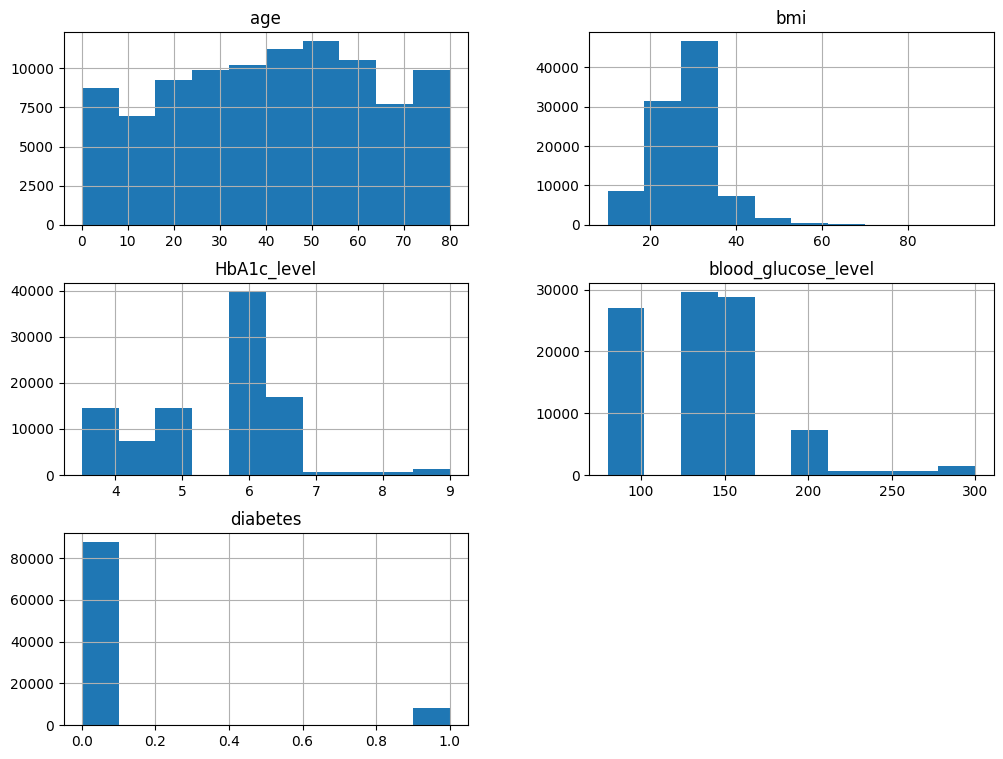

In [117]:
df_copy.hist(figsize=(12, 9))
plt.show()

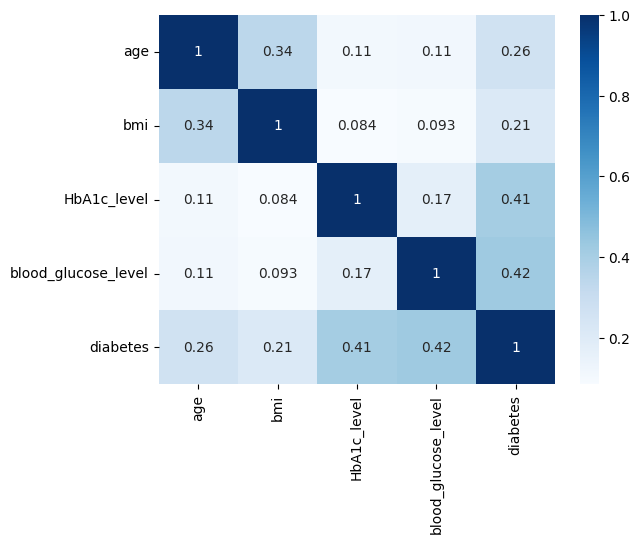

In [74]:
sns.heatmap(df_copy.corr(numeric_only=True), annot=True, cmap=plt.cm.Blues)
plt.show()

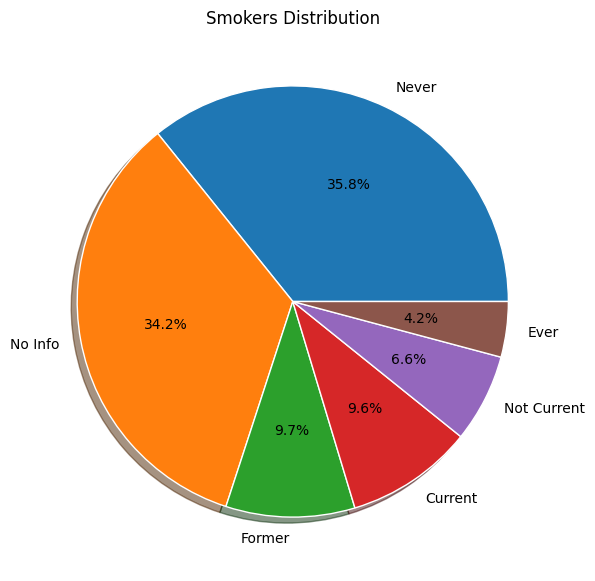

In [84]:
smoking_data = df_copy['smoking_history'].value_counts()
labels = smoking_data.index.str.title().str.replace('_', ' ')
plt.figure(figsize=(7, 7))
plt.pie(smoking_data, labels=labels, 
        autopct='%1.1f%%', shadow=True,
        wedgeprops={'edgecolor': 'white'},)
plt.title('Smokers Distribution')
plt.show()

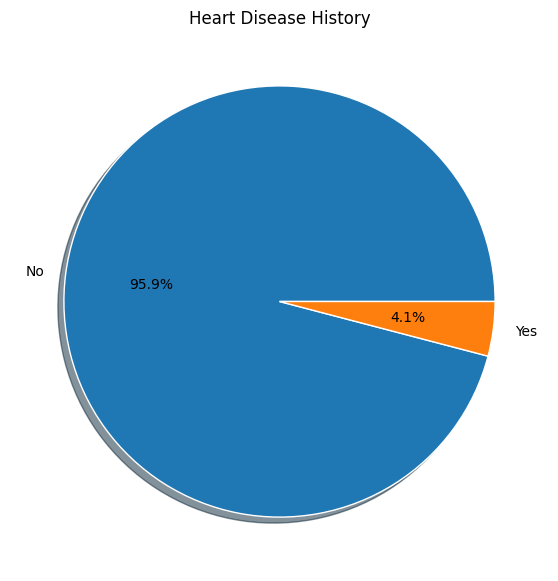

In [85]:
heart_disease_data = df_copy['heart_disease'].value_counts()
labels = heart_disease_data.index.str.title().str.replace('_', ' ')
plt.figure(figsize=(7, 7))
plt.pie(heart_disease_data, labels=labels, 
        autopct='%1.1f%%', shadow=True,
        wedgeprops={'edgecolor': 'white'},)
plt.title('Heart Disease History')
plt.show()

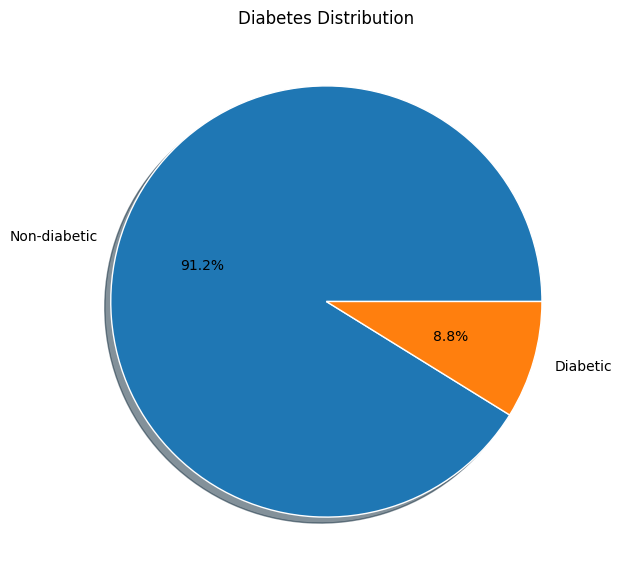

In [91]:
diabetes_data = df_copy['diabetes'].value_counts()
labels = diabetes_data.index.map({0: 'Non-diabetic', 1: 'Diabetic'})
plt.figure(figsize=(7, 7))
plt.pie(diabetes_data, labels=labels, 
        autopct='%1.1f%%', shadow=True,
        wedgeprops={'edgecolor': 'white'},)
plt.title('Diabetes Distribution')
plt.show()

In [102]:
df_copy

,gender,age,hypertension,heart_disease,smoking_history,bmi,HbA1c_level,blood_glucose_level,diabetes
0,Female,80.0,no,yes,never,25.19,6.6,140,0
1,Female,54.0,no,no,no_info,27.32,6.6,80,0
2,Male,28.0,no,no,never,27.32,5.7,158,0
3,Female,36.0,no,no,current,23.45,5.0,155,0
4,Male,76.0,yes,yes,current,20.14,4.8,155,0
...,...,...,...,...,...,...,...,...,...
99994,Female,36.0,no,no,no_info,24.60,4.8,145,0
99996,Female,2.0,no,no,no_info,17.37,6.5,100,0
99997,Male,66.0,no,no,former,27.83,5.7,155,0
99998,Female,24.0,no,no,never,35.42,4.0,100,0


#### Create a Test Set

In [113]:
strat_train, strat_test = train_test_split(df_copy, test_size=.15, 
                                           stratify=df_copy['diabetes'], 
                                           random_state=42)

In [114]:
strat_train_feats = strat_train.drop(columns='diabetes')
strat_train_labels = strat_train['diabetes'].copy()

#### Feature Engineering

In [115]:
def feat_eng(df):
    df['AgeCat'] = pd.cut(df['age'],
                           bins=[-np.inf, 1, 12, 18, 65, np.inf],
                           labels=['infant', 'child', 'teenager', 'adult', 'older_adult'])

    df['BMICat'] = pd.cut(df['bmi'],
                            bins=[-np.inf, 18.5, 25, 30, np.inf],
                            labels=['underweight', 'normal', 'overweight', 'obese'])

    df['GlucoseCat'] = pd.cut(df['blood_glucose_level'],
                                bins=[-np.inf, 140, 200, np.inf],
                                labels=['normal', 'impaired', 'diabetic'])
    
    df['HbA1cCat'] = pd.cut(df['HbA1c_level'],
                            bins=[0, 5.6, 6.4, np.inf],
                            labels=['normal', 'prediabetic', 'diabetic'])
    return df

In [116]:
strat_train_feats = feat_eng(strat_train_feats)
strat_train_feats

,gender,age,hypertension,heart_disease,smoking_history,bmi,HbA1c_level,blood_glucose_level,AgeCat,BMICat,GlucoseCat,HbA1cCat
39454,Female,53.0,no,no,never,27.32,6.0,159,adult,overweight,impaired,prediabetic
53869,Female,10.0,no,no,no_info,18.90,6.2,160,child,normal,impaired,prediabetic
28549,Female,45.0,no,no,no_info,28.80,6.6,80,adult,overweight,normal,diabetic
188,Female,21.0,no,no,current,25.11,6.6,145,adult,overweight,impaired,diabetic
11087,Female,80.0,no,no,never,21.68,6.0,130,older_adult,normal,normal,prediabetic
...,...,...,...,...,...,...,...,...,...,...,...,...
68531,Female,68.0,no,no,not_current,27.32,6.2,90,older_adult,overweight,normal,prediabetic
3044,Female,27.0,no,no,no_info,20.48,3.5,159,adult,normal,impaired,normal
88779,Female,36.0,no,no,current,27.32,6.6,80,adult,overweight,normal,diabetic
96259,Male,7.0,no,no,never,15.80,4.0,158,child,underweight,impaired,normal


#### Pipelining

In [121]:
num_pl = Pipeline([
    ('imputenum', SimpleImputer(strategy='median')),
    ('stdscale', StandardScaler())
])

cat_pl = Pipeline([
    ('imputecat', SimpleImputer(strategy='most_frequent')),
    ('onehotencode', OneHotEncoder(handle_unknown='ignore'))
])

log_pl = Pipeline([
    ('imputelog', SimpleImputer(strategy='median')),
    ('log', FunctionTransformer(np.log1p, feature_names_out='one-to-one')),
    ('stdscalelog', StandardScaler())
])

In [138]:
numerical_columns_except_bmi = list(make_column_selector(dtype_include=np.number)(strat_train_feats))
numerical_columns_except_bmi.remove('bmi')

['age', 'HbA1c_level', 'blood_glucose_level']

In [188]:
preprocessing = ColumnTransformer([
    ('num_pipeline', num_pl, numerical_columns_except_bmi),
    ('log_transform', log_pl, ['bmi']),
    ('cat_pipeline', cat_pl, make_column_selector(dtype_include=['category', 'object']))
])

In [189]:
strat_train_feats_prep = pd.DataFrame(preprocessing.fit_transform(strat_train_feats), 
                                      columns=preprocessing.get_feature_names_out())

In [190]:
strat_train_feats_prep.columns

Index(['num_pipeline__age', 'num_pipeline__HbA1c_level',
       'num_pipeline__blood_glucose_level', 'log_transform__bmi',
       'cat_pipeline__gender_Female', 'cat_pipeline__gender_Male',
       'cat_pipeline__gender_Other', 'cat_pipeline__hypertension_no',
       'cat_pipeline__hypertension_yes', 'cat_pipeline__heart_disease_no',
       'cat_pipeline__heart_disease_yes',
       'cat_pipeline__smoking_history_current',
       'cat_pipeline__smoking_history_ever',
       'cat_pipeline__smoking_history_former',
       'cat_pipeline__smoking_history_never',
       'cat_pipeline__smoking_history_no_info',
       'cat_pipeline__smoking_history_not_current',
       'cat_pipeline__AgeCat_adult', 'cat_pipeline__AgeCat_child',
       'cat_pipeline__AgeCat_infant', 'cat_pipeline__AgeCat_older_adult',
       'cat_pipeline__AgeCat_teenager', 'cat_pipeline__BMICat_normal',
       'cat_pipeline__BMICat_obese', 'cat_pipeline__BMICat_overweight',
       'cat_pipeline__BMICat_underweight', 'cat_pipel

#### Try Various Models

In [191]:
log_reg = make_pipeline(preprocessing, LogisticRegression(random_state=42))
sgd = make_pipeline(preprocessing, SGDClassifier(random_state=42))
dt = make_pipeline(preprocessing, DecisionTreeClassifier(random_state=42))
svm = make_pipeline(preprocessing, SVC(random_state=42))
rf = make_pipeline(preprocessing, RandomForestClassifier(random_state=42))
gb = make_pipeline(preprocessing, GradientBoostingClassifier(random_state=42))

In [192]:
models = [log_reg, sgd, dt, svm, rf, gb]
for model in models:
    model.fit(strat_train_feats, strat_train_labels)

In [193]:
def calc_prec_recall(model):
    y_train_pred = cross_val_predict(model, strat_train_feats, strat_train_labels, cv=3)
    precesion = precision_score(strat_train_labels, y_train_pred)
    recall = recall_score(strat_train_labels, y_train_pred)
    roc_auc = roc_auc_score(strat_train_labels, y_train_pred)
    print(f'{model.steps[-1][1].__class__.__name__}\nPrecesion: {precesion}\nRecall: {recall}\nROC_AUC_Score: {roc_auc}\n')

In [194]:
for model in models:
    calc_prec_recall(model)

LogisticRegression
Precesion: 0.9417495433326568
Recall: 0.6435506241331485
ROC_AUC_Score: 0.8198494994675996

SGDClassifier
Precesion: 0.9995379995379995
Recall: 0.6001386962552011
ROC_AUC_Score: 0.8000559278307436

DecisionTreeClassifier
Precesion: 0.6964914568931786
Recall: 0.7406380027739251
ROC_AUC_Score: 0.854704485993882

SVC
Precesion: 0.9975977287617384
Recall: 0.6335644937586685
ROC_AUC_Score: 0.816708435246621

RandomForestClassifier
Precesion: 0.9284510207904102
Recall: 0.6875173370319001
ROC_AUC_Score: 0.8411953918162695

GradientBoostingClassifier
Precesion: 0.98001998001998
Recall: 0.6803051317614425
ROC_AUC_Score: 0.8394815510378728



In [195]:
y_pred_gb = gb.predict(strat_train_feats)

In [196]:
class_report_str = classification_report(strat_train_labels, y_pred_gb, digits=2)
class_report_list = class_report_str.split('\n')[2:-5]
class_data = [line.split() for line in class_report_list]
class_report_df = pd.DataFrame(class_data, columns=['class', 'precision', 'recall', 'f1-score', 'support'])
class_report_df.set_index('class', inplace=True)

In [197]:
class_report_df

,precision,recall,f1-score,support
class,,,,
0,0.97,1.00,0.98,74514
1,0.99,0.68,0.81,7210


#### Fine Tuning

In [198]:
full_pl = Pipeline([
    ('preprocessing', preprocessing),
    ('gradient_boosting_clf', GradientBoostingClassifier(random_state=42))
])

In [199]:
param_grid = [
    {
        'preprocessing__num_pipeline__imputenum__strategy': ['mean', 'median'],
        'preprocessing__num_pipeline__stdscale__with_mean': [True, False],
        'preprocessing__num_pipeline__stdscale__with_std': [True, False],
        
        'preprocessing__log_transform__imputelog__strategy': ['mean', 'median'],
        'preprocessing__log_transform__log__func': [None, np.log1p, np.log10],  # 'None' means no log transformation
        'preprocessing__log_transform__stdscalelog__with_mean': [True, False],
        'preprocessing__log_transform__stdscalelog__with_std': [True, False],
        
        'gradient_boosting_clf__learning_rate': [0.01, 0.1, 0.2, 0.3],
        'gradient_boosting_clf__n_estimators': [50, 100, 200, 300],
        'gradient_boosting_clf__max_depth': [3, 4, 5, 6],
        'gradient_boosting_clf__min_samples_split': [2, 5, 10],
        'gradient_boosting_clf__min_samples_leaf': [1, 2, 4],
    }
]

In [203]:
grid_search = RandomizedSearchCV(full_pl, param_distributions=param_grid,
                                 n_iter=10, cv=3, n_jobs=-1, random_state=42)
grid_search.fit(strat_train_feats, strat_train_labels)

RandomizedSearchCV(cv=3,
                   estimator=Pipeline(steps=[('preprocessing',
                                              ColumnTransformer(transformers=[('num_pipeline',
                                                                               Pipeline(steps=[('imputenum',
                                                                                                SimpleImputer(strategy='median')),
                                                                                               ('stdscale',
                                                                                                StandardScaler())]),
                                                                               ['age',
                                                                                'HbA1c_level',
                                                                                'blood_glucose_level']),
                                                                              ('log_transform',
                                                                               Pipeline(steps=[('imputelog',
                                                                                                SimpleImputer(strategy='median')),
                                                                                               ('log',
                                                                                                Function...
                                                                                     <ufunc 'log10'>],
                                         'preprocessing__log_transform__stdscalelog__with_mean': [True,
                                                                                                  False],
                                         'preprocessing__log_transform__stdscalelog__with_std': [True,
                                                                                                 False],
                                         'preprocessing__num_pipeline__imputenum__strategy': ['mean',
                                                                                              'median'],
                                         'preprocessing__num_pipeline__stdscale__with_mean': [True,
                                                                                              False],
                                         'preprocessing__num_pipeline__stdscale__with_std': [True,
                                                                                             False]}],
                   random_state=42)

In [205]:
grid_search.best_params_

{'preprocessing__num_pipeline__stdscale__with_std': True,
 'preprocessing__num_pipeline__stdscale__with_mean': False,
 'preprocessing__num_pipeline__imputenum__strategy': 'mean',
 'preprocessing__log_transform__stdscalelog__with_std': False,
 'preprocessing__log_transform__stdscalelog__with_mean': True,
 'preprocessing__log_transform__log__func': <ufunc 'log1p'>,
 'preprocessing__log_transform__imputelog__strategy': 'median',
 'gradient_boosting_clf__n_estimators': 100,
 'gradient_boosting_clf__min_samples_split': 2,
 'gradient_boosting_clf__min_samples_leaf': 2,
 'gradient_boosting_clf__max_depth': 4,
 'gradient_boosting_clf__learning_rate': 0.1}

In [206]:
grid_search.best_score_

0.9706206154796443

In [214]:
final_model = grid_search.best_estimator_

In [258]:
feat_importance = sorted(zip(final_model['gradient_boosting_clf'].feature_importances_,
           final_model['preprocessing'].get_feature_names_out()),
           reverse=True)[:15]
feat_importance

[(0.623169901129787, 'num_pipeline__HbA1c_level'),
 (0.1661074056939408, 'num_pipeline__blood_glucose_level'),
 (0.1547129528457443, 'cat_pipeline__GlucoseCat_diabetic'),
 (0.020182984688037944, 'num_pipeline__age'),
 (0.01369032405200655, 'cat_pipeline__HbA1cCat_normal'),
 (0.012341467605327124, 'log_transform__bmi'),
 (0.003507883379827659, 'cat_pipeline__hypertension_no'),
 (0.001493408721581158, 'cat_pipeline__heart_disease_no'),
 (0.0014118342794553443, 'cat_pipeline__heart_disease_yes'),
 (0.0007595691467861506, 'cat_pipeline__smoking_history_no_info'),
 (0.0006743199714354519, 'cat_pipeline__hypertension_yes'),
 (0.0006222794041982635, 'cat_pipeline__gender_Male'),
 (0.0005647413263977864, 'cat_pipeline__AgeCat_older_adult'),
 (0.00039303227436213476, 'cat_pipeline__HbA1cCat_prediabetic'),
 (0.0001250850475373963, 'cat_pipeline__smoking_history_never')]

In [285]:
num_data = sorted(final_model['gradient_boosting_clf'].feature_importances_, reverse=True)[:6]

In [286]:
col_names = [col_name.split('__')[-1] for _, col_name in feat_importance][:6]

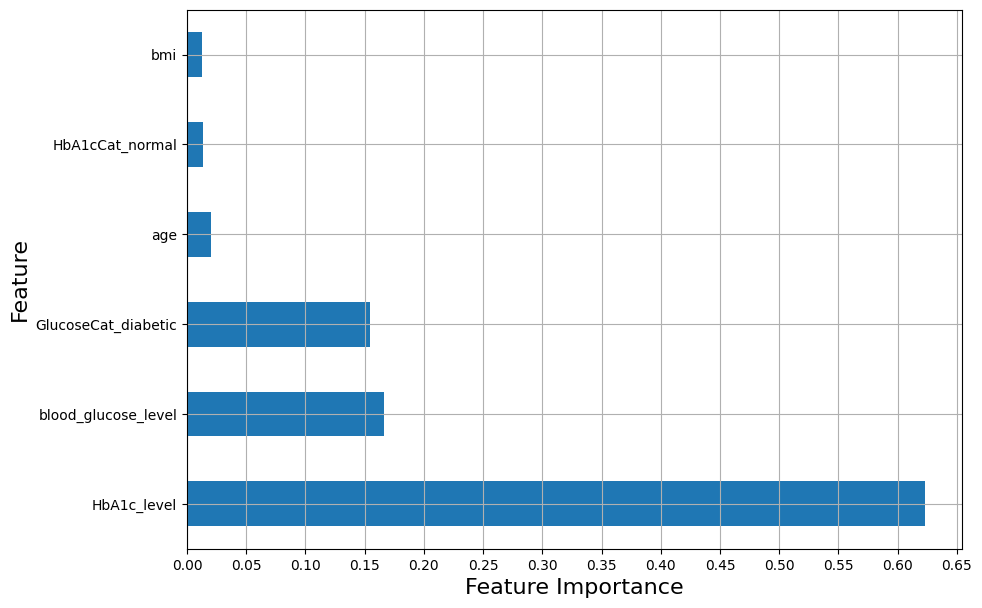

In [295]:
plt.figure(figsize=(10, 7))
pd.Series(num_data, index=col_names).plot(kind='barh')
plt.grid()
plt.xticks(np.arange(0, .7, .05))
plt.tick_params(axis='x', labelsize=10)
plt.tick_params(axis='y', labelsize=10) 
plt.xlabel('Feature Importance', fontsize=16)
plt.ylabel('Feature', fontsize=16)
plt.show()

#### Test the Model on the Test Set

In [229]:
strat_test_feats = strat_test.drop(columns='diabetes')
strat_test_labels = strat_test['diabetes']

In [232]:
strat_test_feats = feat_eng(strat_test_feats)

In [239]:
final_model_pred = final_model.predict(strat_test_feats)
accuracy = accuracy_score(strat_test_labels, final_model_pred)
precision = precision_score(strat_test_labels, final_model_pred)
recall = recall_score(strat_test_labels, final_model_pred)
f1 = f1_score(strat_test_labels, final_model_pred)
roc_auc = roc_auc_score(strat_test_labels, final_model_pred)
conf_matrix = confusion_matrix(strat_test_labels, final_model_pred)

print("Accuracy:", accuracy)
print("Precision:", precision)
print("Recall:", recall)
print("F1-score:", f1)
print("ROC AUC:", roc_auc)
print("Confusion Matrix:")
print(conf_matrix)

Accuracy: 0.9724032727777008
Precision: 0.9888143176733781
Recall: 0.6949685534591195
F1-score: 0.8162511542012927
ROC AUC: 0.8471040485926775
Confusion Matrix:
[[13140    10]
 [  388   884]]


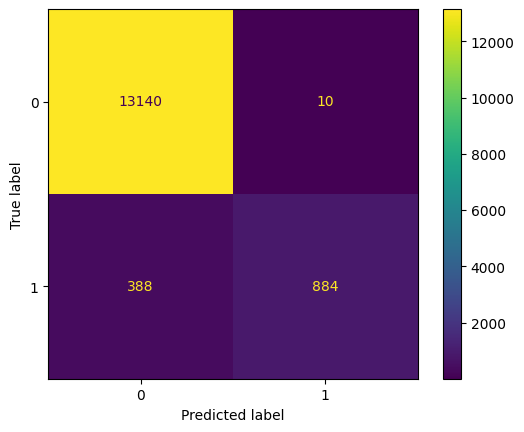

In [247]:
disp = ConfusionMatrixDisplay(confusion_matrix=conf_matrix, display_labels=model.classes_)
disp.plot(cmap='viridis', values_format='d')
plt.show()

#### Save the Model

In [248]:
joblib.dump(final_model, 'final_model.pkl')

['final_model.pkl']